In [25]:
import csv
from typing import Optional
import random
import arrow
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.src.layers import LSTM, Dropout, Dense
from pandas import DatetimeIndex
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 可视化结果（如果需要）
import matplotlib.pyplot as plt
import os
import pathlib
import xml.etree.ElementTree as ET
import xarray as xr
import codecs
import datetime

# 先从海浪数据中提取出经纬度，时间，风，海浪高度
# 解析单个文件，并存于字典内
from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import sys


In [26]:
# 注意使用此种方式可以引入 root_path/utils/...
sys.path.append('./../../')

In [51]:
from utils.common import get_forecast_df,get_realdata_df

In [28]:
read_path='/Volumes/DATA/01TRAINNING_DATA/WIND/01/merge.csv'

In [29]:
df=pd.read_csv(read_path,encoding='utf-8')

In [30]:
df.head()

,Unnamed: 0.11,20240101000000_u,20240101000000_v,20240101120000_u,20240101120000_v,20240102000000_u,20240102000000_v,20240102120000_u,20240102120000_v,20240103000000_u,...,20241229120000_u,20241229120000_v,20241230000000_u,20241230000000_v,20241230120000_u,20241230120000_v,20241231000000_u,20241231000000_v,20241231120000_u,20241231120000_v
0,0,2.766523,-0.946262,9.075234,2.101646,5.002740,-0.315947,2.675060,-2.737531,-2.128356,...,7.761340,4.656658,5.450808,-3.068711,0.967666,-10.772373,-0.954367,-2.536609,11.587268,1.256021
1,1,6.289143,1.760215,10.067031,1.336572,3.949260,-0.545807,2.952109,-2.619555,-1.010674,...,8.965315,1.146887,6.532539,-3.778604,1.168074,-8.201670,3.130037,4.055197,10.210252,-1.778598
2,2,8.247787,3.317518,9.048562,-0.392486,3.358205,-0.582189,2.343160,-4.291770,2.870877,...,8.917482,-0.343029,2.933635,-8.441518,2.046308,-8.980049,9.071998,2.749836,0.852088,-7.120406
3,3,8.072305,4.068276,6.563037,-1.111190,4.347986,-1.305656,0.012131,-8.769397,3.517645,...,7.942695,-2.584281,2.642920,-10.316483,0.407965,-7.099033,10.491653,2.653147,-5.840176,-6.524525
4,4,8.055267,3.163379,3.616818,-1.975365,2.872303,-2.846676,0.777438,-7.239537,5.865928,...,5.601176,-4.565322,2.406543,-10.625953,0.125789,-2.112356,11.386693,0.591938,-5.267455,-6.742672


In [31]:
# TODO:[*] 25-04-29 根据起止时间，时间步长为12h，生成发布时间index
start_time = '2024-01-01 00:00:00'
end_time = '2024-12-31 23:00:00'
issue_times_index = pd.date_range(start=start_time, end=end_time, freq='12h')

In [32]:
df_u,df_v=get_forecast_df(read_path,'',issue_times_index)

当前列:Unnamed: 0.11处理错误!
当前列:20240101000000_u处理成功~
当前列:20240101000000_v处理成功~
当前列:20240101120000_u处理成功~
当前列:20240101120000_v处理成功~
当前列:20240102000000_u处理成功~
当前列:20240102000000_v处理成功~
当前列:20240102120000_u处理成功~
当前列:20240102120000_v处理成功~
当前列:20240103000000_u处理成功~
当前列:20240103000000_v处理成功~
当前列:20240103120000_u处理成功~
当前列:20240103120000_v处理成功~
当前列:20240104000000_u处理成功~
当前列:20240104000000_v处理成功~
当前列:20240104120000_u处理成功~
当前列:20240104120000_v处理成功~
当前列:20240105000000_u处理成功~
当前列:20240105000000_v处理成功~
当前列:20240105120000_u处理成功~
当前列:20240105120000_v处理成功~
当前列:20240106000000_u处理成功~
当前列:20240106000000_v处理成功~
当前列:20240106120000_u处理成功~
当前列:20240106120000_v处理成功~
当前列:20240107000000_u处理成功~
当前列:20240107000000_v处理成功~
当前列:20240107120000_u处理成功~
当前列:20240107120000_v处理成功~
当前列:20240108000000_u处理成功~
当前列:20240108000000_v处理成功~
当前列:20240108120000_u处理成功~
当前列:20240108120000_v处理成功~
当前列:20240109000000_u处理成功~
当前列:20240109000000_v处理成功~
当前列:20240109120000_u处理成功~
当前列:20240109120000_v处理成功~
当前列:20240110000000_u处理成功~
当前列:20240110000

### step1: 读取合并后的全年单点预报数据  
`u`与`v`两个分量

In [34]:
df_u.shape

(72, 732)

In [35]:
df_v.shape

(72, 732)

In [36]:
df_u

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 00:00:00,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00
0,2.766523,9.075234,5.002740,2.675060,-2.128356,5.750553,5.524846,6.929520,-4.396342,4.942668,...,-1.488314,5.846275,6.208457,5.701063,5.534662,7.761340,5.450808,0.967666,-0.954367,11.587268
1,6.289143,10.067031,3.949260,2.952109,-1.010674,7.330463,6.257961,6.028646,-3.273404,6.492066,...,0.759490,4.243312,8.501439,5.532340,5.126281,8.965315,6.532539,1.168074,3.130037,10.210252
2,8.247787,9.048562,3.358205,2.343160,2.870877,6.602916,8.165231,-2.086420,-0.033990,7.097127,...,3.662455,2.494381,9.567039,4.299193,7.128920,8.917482,2.933635,2.046308,9.071998,0.852088
3,8.072305,6.563037,4.347986,0.012131,3.517645,7.347518,8.678781,-3.710930,3.385559,0.824375,...,4.914733,7.708490,6.961527,5.321861,8.195963,7.942695,2.642920,0.407965,10.491653,-5.840176
4,8.055267,3.616818,2.872303,0.777438,5.865928,6.892735,8.249434,-2.451965,6.310976,-0.923490,...,6.868699,9.339152,5.045971,6.596740,9.859485,5.601176,2.406543,0.125789,11.386693,-5.267455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### step2: 生成风速绝对值

In [39]:
df_ws_forecast = np.sqrt(df_u ** 2 + df_v ** 2)
"""风速绝对值"""

'风速绝对值'

In [40]:
df_ws_forecast.head()

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 00:00:00,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00
0,2.923878,9.315406,5.012707,3.827535,7.922782,7.508249,10.098755,6.931345,7.173455,5.142837,...,8.743365,8.087823,6.933784,5.954374,5.939341,9.051125,6.255262,10.815748,2.710204,11.655143
1,6.530825,10.155370,3.986798,3.946773,5.445124,9.135552,9.633334,9.233833,3.393676,6.577634,...,8.122977,9.979736,8.622316,6.085054,8.969516,9.038375,7.546649,8.284430,5.122671,10.364008
2,8.889989,9.057070,3.408297,4.889753,3.289932,9.488909,10.207234,10.298507,1.344447,7.846056,...,7.816586,8.706822,9.970959,4.476284,11.169362,8.924077,8.936747,9.210247,9.479596,7.171209
3,9.039523,6.656440,4.539793,8.769405,4.212557,10.969419,8.871683,10.377746,4.269206,8.143950,...,7.456558,8.165563,7.588914,5.417556,11.360951,8.352539,10.649641,7.110746,10.821920,8.756545
4,8.654149,4.121097,4.043969,7.281161,7.424704,11.250175,8.345333,6.764350,6.505871,9.279316,...,8.452628,9.429845,5.237637,7.014868,10.349231,7.226018,10.895060,2.116098,11.402069,8.556267


### step3: 对columns进行排序

In [45]:
df_ws_forecast.sort_index(axis=1, ascending=True, inplace=True)

In [46]:
df_ws_forecast

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 00:00:00,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00
0,2.923878,9.315406,5.012707,3.827535,7.922782,7.508249,10.098755,6.931345,7.173455,5.142837,...,8.743365,8.087823,6.933784,5.954374,5.939341,9.051125,6.255262,10.815748,2.710204,11.655143
1,6.530825,10.155370,3.986798,3.946773,5.445124,9.135552,9.633334,9.233833,3.393676,6.577634,...,8.122977,9.979736,8.622316,6.085054,8.969516,9.038375,7.546649,8.284430,5.122671,10.364008
2,8.889989,9.057070,3.408297,4.889753,3.289932,9.488909,10.207234,10.298507,1.344447,7.846056,...,7.816586,8.706822,9.970959,4.476284,11.169362,8.924077,8.936747,9.210247,9.479596,7.171209
3,9.039523,6.656440,4.539793,8.769405,4.212557,10.969419,8.871683,10.377746,4.269206,8.143950,...,7.456558,8.165563,7.588914,5.417556,11.360951,8.352539,10.649641,7.110746,10.821920,8.756545
4,8.654149,4.121097,4.043969,7.281161,7.424704,11.250175,8.345333,6.764350,6.505871,9.279316,...,8.452628,9.429845,5.237637,7.014868,10.349231,7.226018,10.895060,2.116098,11.402069,8.556267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### step4: 读取实况数据

In [52]:
real_data_path:str=r'/Volumes/DATA/FUB/MF01001/2024_local.csv'

In [54]:
df_realdata=get_realdata_df(real_data_path)

/Users/evaseemefly/02proj/MLProj/byJupyter/02-数据绘图/./../../utils/common.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_series = pd.date_range(start=start_time, end=end_time, freq='H')
/Users/evaseemefly/02proj/MLProj/byJupyter/02-数据绘图/./../../utils/common.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utc_times = pd.date_range(start=start_time_utc, end=end_time_utc, freq='H', tz='utc')
/Users/evaseemefly/02proj/MLProj/byJupyter/02-数据绘图/./../../utils/common.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  issue_dt_series = pd.date_range(start=start_time_split_utc, end=end_time_split_utc, freq=freq_str, tz='utc')


In [55]:
df_realdata.sort_index(axis=1, ascending=True, inplace=True)

In [56]:
df_realdata.head()

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 00:00:00,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00
0,4.0,12.8,4.5,2.4,8.8,9.1,11.8,9.1,4.7,5.6,...,8.6,8.8,9.5,5.7,7.2,8.5,8.2,9.7,1.7,12.0
1,5.3,11.1,4.4,2.5,7.0,9.7,10.9,8.8,4.1,4.9,...,8.8,9.4,9.2,5.0,7.6,8.9,7.5,8.3,1.6,10.8
2,6.4,9.9,0.0,3.9,6.4,10.8,10.4,8.5,3.8,6.6,...,9.2,10.6,8.0,5.4,6.4,7.8,6.4,6.3,2.1,9.3
3,0.0,9.3,0.0,4.6,0.0,9.6,0.0,7.5,0.0,6.5,...,7.0,9.2,7.1,5.3,9.5,8.9,7.6,5.6,4.8,8.8
4,8.1,10.4,1.5,2.7,5.5,9.8,8.2,6.7,0.8,7.4,...,7.5,8.4,6.5,4.8,10.2,8.8,7.2,8.1,7.6,NaN


In [57]:
df_realdata.shape

(72, 732)

,2024-01-01 00:00:00,2024-01-01 12:00:00,2024-01-02 00:00:00,2024-01-02 12:00:00,2024-01-03 00:00:00,2024-01-03 12:00:00,2024-01-04 00:00:00,2024-01-04 12:00:00,2024-01-05 00:00:00,2024-01-05 12:00:00,...,2024-12-27 00:00:00,2024-12-27 12:00:00,2024-12-28 00:00:00,2024-12-28 12:00:00,2024-12-29 00:00:00,2024-12-29 12:00:00,2024-12-30 00:00:00,2024-12-30 12:00:00,2024-12-31 00:00:00,2024-12-31 12:00:00
0,4.0,12.8,4.5,2.4,8.8,9.1,11.8,9.1,4.7,5.6,...,8.6,8.8,9.5,5.7,7.2,8.5,8.2,9.7,1.7,12.0
1,5.3,11.1,4.4,2.5,7.0,9.7,10.9,8.8,4.1,4.9,...,8.8,9.4,9.2,5.0,7.6,8.9,7.5,8.3,1.6,10.8
2,6.4,9.9,0.0,3.9,6.4,10.8,10.4,8.5,3.8,6.6,...,9.2,10.6,8.0,5.4,6.4,7.8,6.4,6.3,2.1,9.3
3,0.0,9.3,0.0,4.6,0.0,9.6,0.0,7.5,0.0,6.5,...,7.0,9.2,7.1,5.3,9.5,8.9,7.6,5.6,4.8,8.8
4,8.1,10.4,1.5,2.7,5.5,9.8,8.2,6.7,0.8,7.4,...,7.5,8.4,6.5,4.8,10.2,8.8,7.2,8.1,7.6,NaN


### step5: 随机取10个index

In [50]:
np.random.randint(0, 731, size=10).tolist()

[424, 425, 0, 174, 164, 695, 350, 156, 489, 261]

In [60]:
temp_index=35

In [65]:
series_forecast = df_ws_forecast.iloc[:,temp_index]
series_forecast

0     13.135273
1     13.849998
2     14.294449
3     14.346926
4     15.316258
        ...    
67          NaN
68          NaN
69          NaN
70          NaN
71          NaN
Name: 2024-01-18 12:00:00, Length: 72, dtype: float64

In [64]:
series_realdata=df_realdata.iloc[:,temp_index]
series_realdata

0     14.9
1     14.7
2     13.7
3     14.6
4     15.7
      ... 
67    11.4
68    10.2
69    11.0
70    10.7
71    12.9
Name: 2024-01-18 12:00:00, Length: 72, dtype: float64

In [66]:
import matplotlib.pyplot as plt

In [67]:
x=np.arange(72)

/Users/evaseemefly/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evaseemefly/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evaseemefly/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evaseemefly/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evaseemefly/opt/anaconda3/envs/py39/lib/pytho

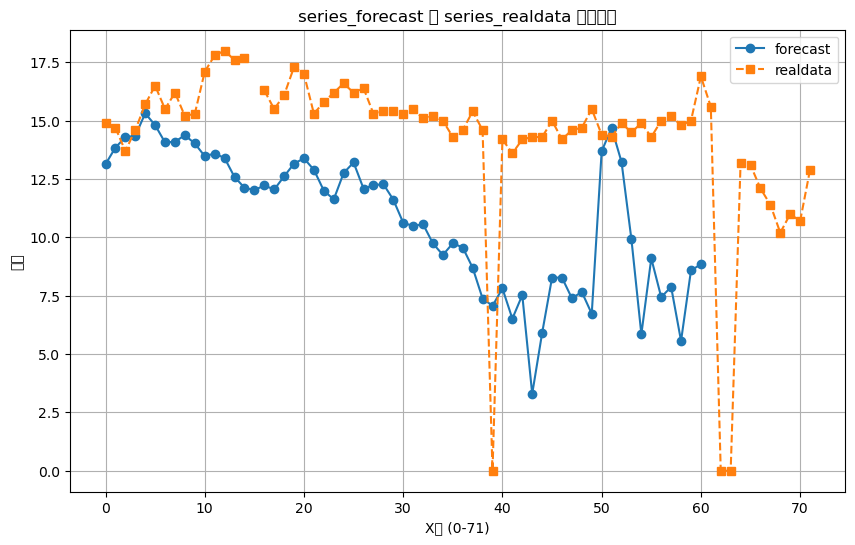

In [69]:
# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x, series_forecast, marker='o', linestyle='-', label='forecast')
plt.plot(x, series_realdata, marker='s', linestyle='--', label='realdata')

plt.xlabel('X轴 (0-71)')
plt.ylabel('数值')
plt.title('series_forecast 和 series_realdata 的折线图')
plt.legend()
plt.grid(True)

plt.show()

/Users/evaseemefly/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evaseemefly/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evaseemefly/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evaseemefly/opt/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/evaseemefly/opt/anaconda3/envs/py39/lib/pytho

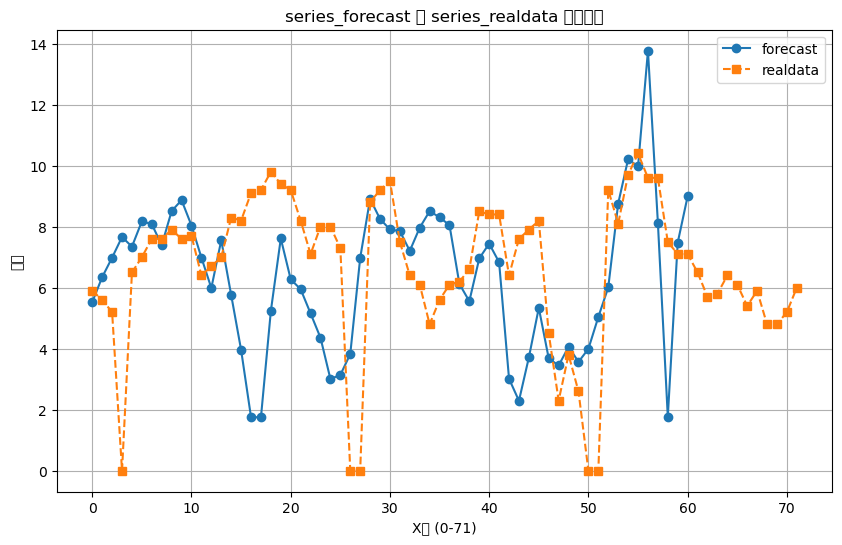

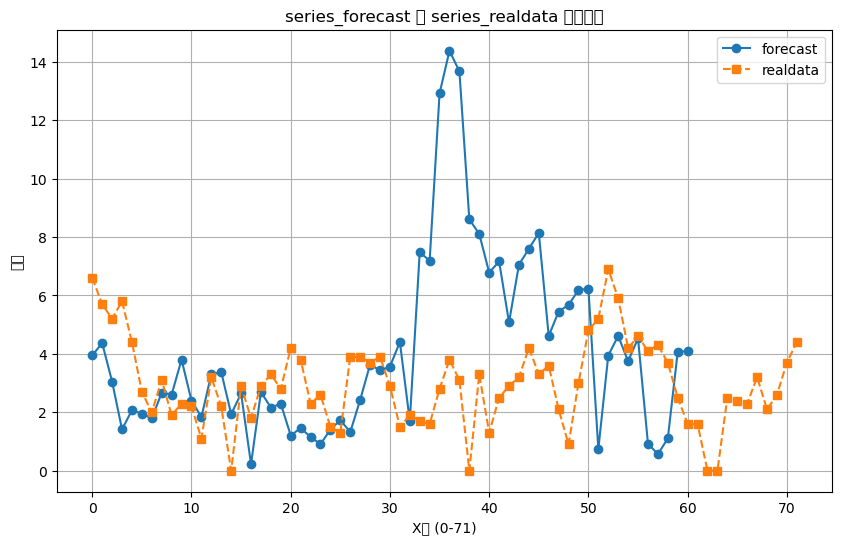

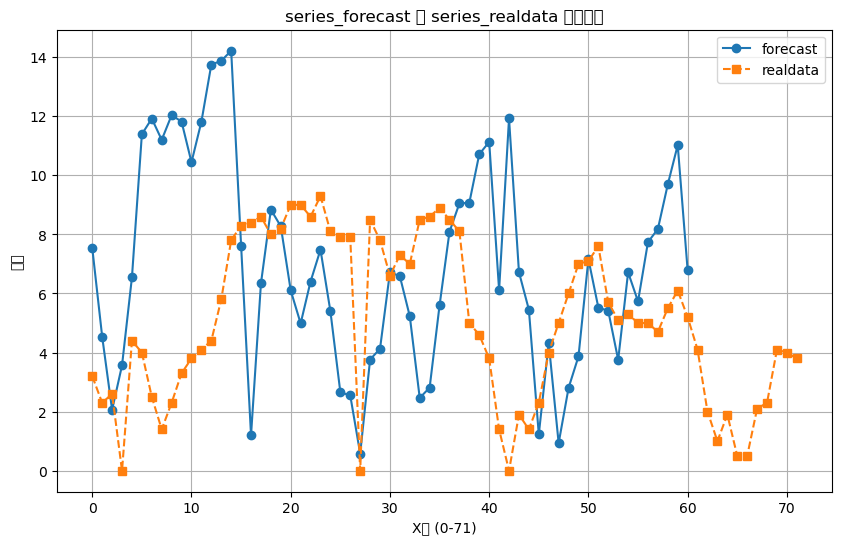

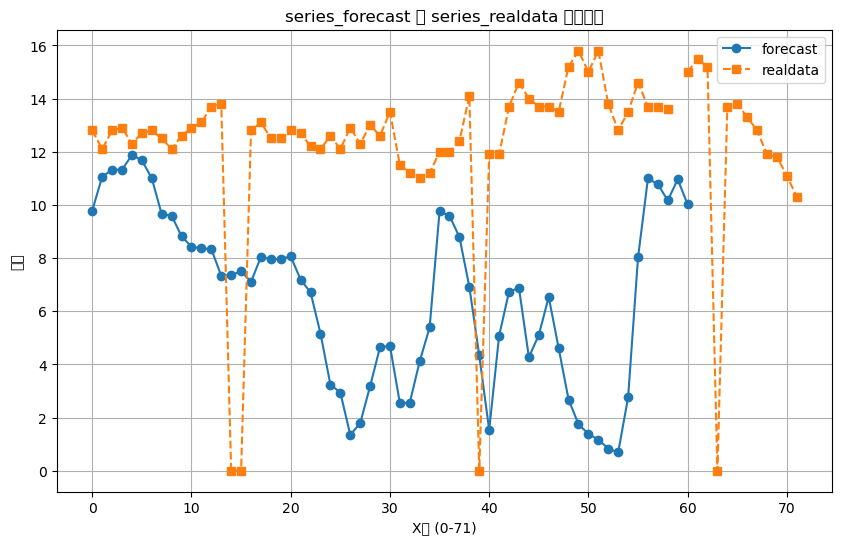

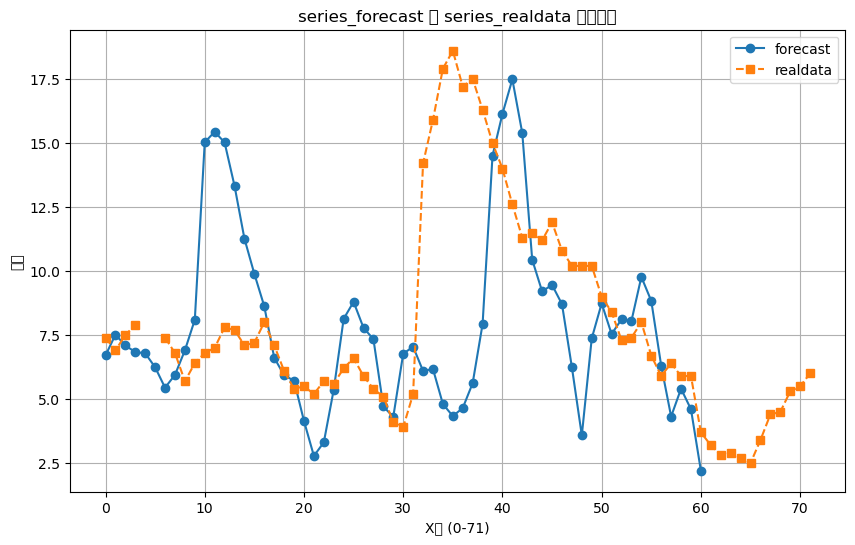

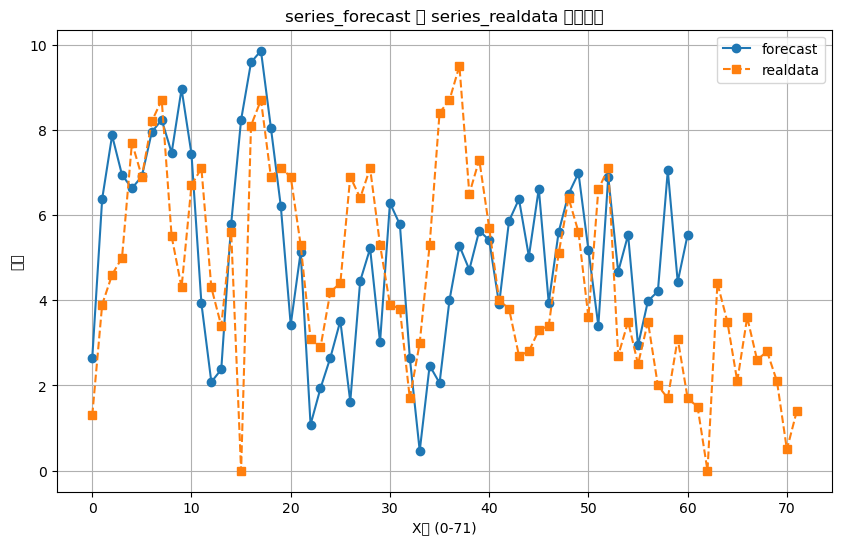

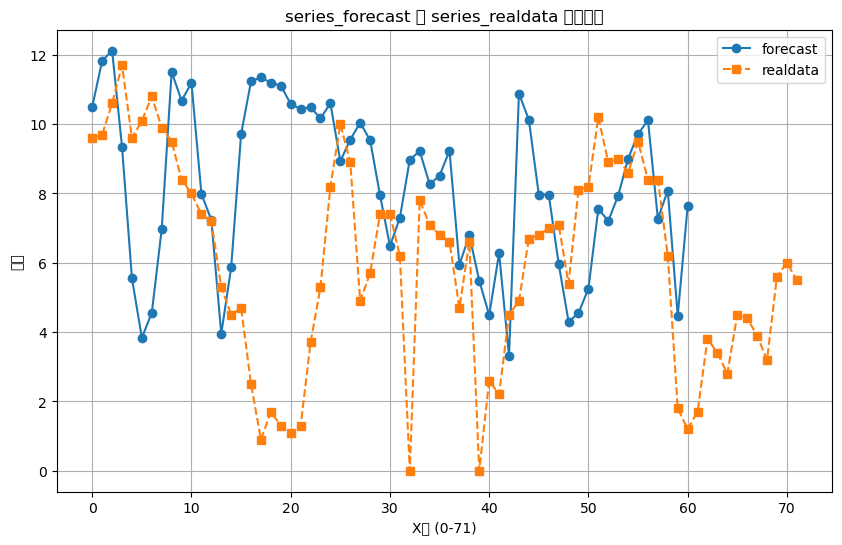

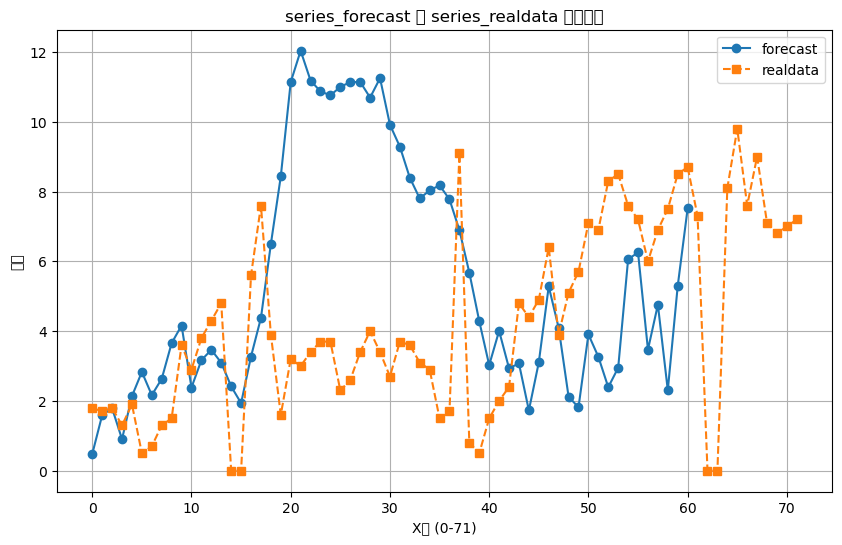

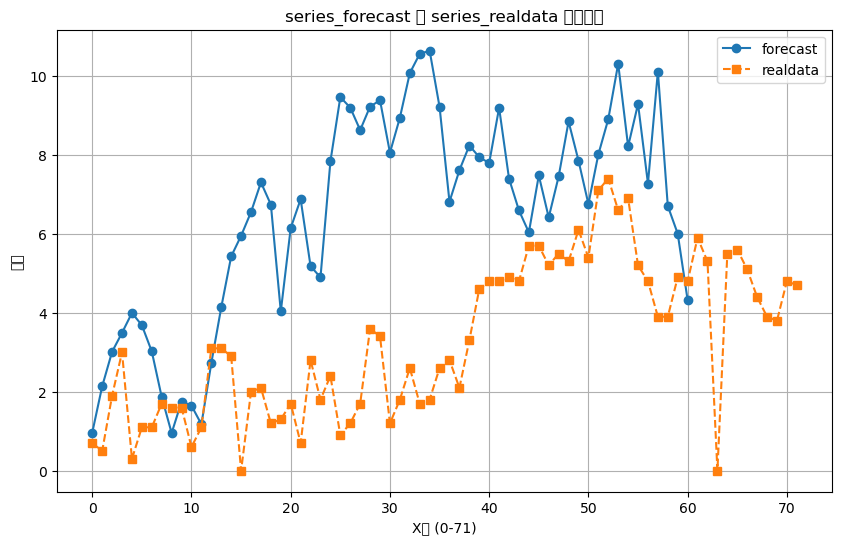

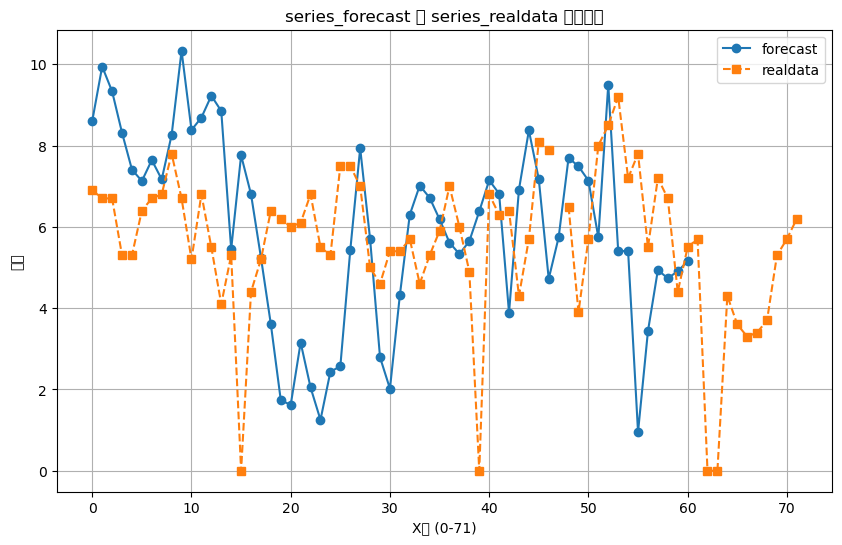

In [70]:
index_list=np.random.randint(0, 731, size=10).tolist()
for i in index_list:
    series_forecast = df_ws_forecast.iloc[:, i]
    series_realdata = df_realdata.iloc[:, i]

    # 绘制图形
    plt.figure(figsize=(10, 6))
    plt.plot(x, series_forecast, marker='o', linestyle='-', label='forecast')
    plt.plot(x, series_realdata, marker='s', linestyle='--', label='realdata')

    plt.xlabel('X轴 (0-71)')
    plt.ylabel('数值')
    plt.title('series_forecast 和 series_realdata 的折线图')
    plt.legend()
    plt.grid(True)

    plt.show()